# Optimisation: Bare-bones CMA-ES

PINTS has two implementations of the CMA-ES algorithm:

1. The main one, called [CMA-ES](http://pints.readthedocs.io/en/latest/optimisers/cmaes.html), wraps around a battle-tested routine by the original authors of the algorithm.
   This is the version we recommend for normal use.
2. For users interested in exploring the algorhitm, PINTS also contains a [bare-bones CMA-ES reimplementation](http://pints.readthedocs.io/en/latest/optimisers/cmaes_bare.html).
   This version doesn't have all the features of the main implementation, which may make it easier to understand or compare to other, similar, algorithms.

In this example we visualise a short optimisation with CMA-ES.

## First example: finding the bottom of a parabolic valley

We start off by defining a simple error function: a parabola centered at the origin:

In [1]:
import pints
import pints.toy

# Create a parabolic error function
error = pints.toy.ParabolicError()

To see what this function looks like, we'll use a contour plot.

This will get re-used throughout the example, so we define a function to create it:

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the error function on a grid of points
X = np.arange(-2, 2.1, 0.1)
Y = np.arange(-1, 1.1, 0.1)
Z = np.zeros((len(Y), len(X)))
for i, x in enumerate(X):
    for j, y in enumerate(Y):
        Z[j, i] = error((x, y))
X, Y = np.meshgrid(X, Y)

# Define a function to create a contour plot
def create_contour_plot():

    # Create figure
    fig = plt.figure(figsize=(16, 8))
    ax = plt.subplot(1, 1, 1)
    plt.xlim(-2, 2)
    plt.ylim(-1, 1)

    # Plot the contours
    plt.contour(X, Y, Z, levels=20)
    
    # Show where the optimum is
    plt.plot([0], [0], 'o', label='optimum')

Next, we'll choose a starting point for our optimisation, and plot it on the contours of the error function:

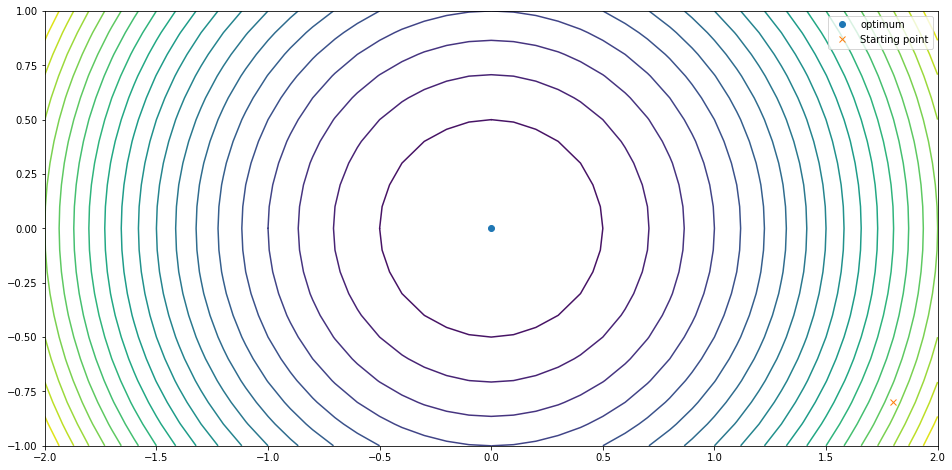

In [15]:
# Create a contour plot
create_contour_plot()

# Choose a starting point for the optimisation
x0 = [1.8, -0.8]

# Show the starting point
plt.plot(x0[0], x0[1], 'x', label='Starting point')

# Show the whole figure
plt.legend()
plt.show()

At this stage, our problem is all set up.

The next thing to do is to create a bare-bones CMA-ES optimiser, and use the ask-and-tell interface to let it walk a few steps. We can use the `mean()` method to obtain the CMA-ES optimiser's current position:

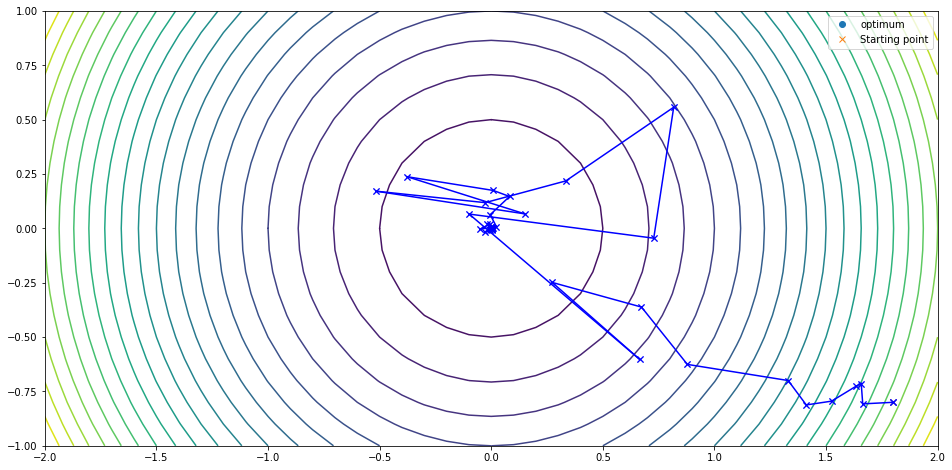

In [17]:
# Create a nice plot
create_contour_plot()
plt.plot(x0[0], x0[1], 'x', label='Starting point')

# Create a CMA-ES optimiser
sigma0 = 0.1
opt = pints.BareCMAES(x0, sigma0)

# Create an evaluator to evaluate the error function
e = pints.SequentialEvaluator(error)

# Walk a few steps, and plot the results
x1 = x0
for i in range(50):
    x2 = opt.mean()
    plt.plot((x1[0], x2[0]), (x1[1], x2[1]), 'x-', color='blue')
    x1 = x2
    
    xs = opt.ask()
    fs = e.evaluate(xs)
    opt.tell(fs)

# Show the whole figure
plt.legend()
plt.show()

This looks a little bit insane! Especially if we compare it to a simpler optimiser:

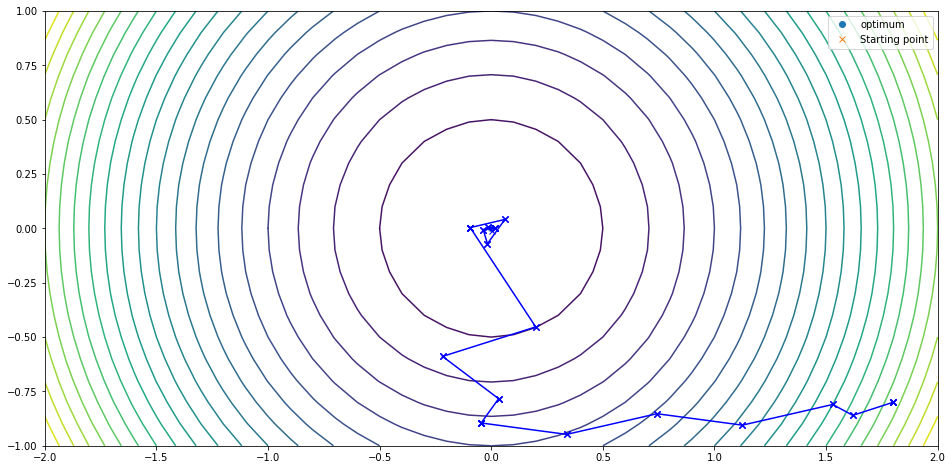

In [19]:
# Create a nice plot
create_contour_plot()
plt.plot(x0[0], x0[1], 'x', label='Starting point')

# Create a CMA-ES optimiser
sigma0 = 0.1
opt = pints.NelderMead(x0, sigma0)

# Create an evaluator to evaluate the error function
e = pints.SequentialEvaluator(error)

# Walk a few steps, and plot the results
x1 = x0
for i in range(50):
    x2 = opt.xbest()
    plt.plot((x1[0], x2[0]), (x1[1], x2[1]), 'x-', color='blue')
    x1 = x2
    
    xs = opt.ask()
    fs = e.evaluate(xs)
    opt.tell(fs)

# Show the whole figure
plt.legend()
plt.show()

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Time m:s
0     6      1521065    0:00.1
1     12     1521065    0:00.1
2     18     1521065    0:00.1
3     24     1521065    0:00.1
20    126    1256284    0:00.2
40    246    1250171    0:00.2
60    366    347036.8   0:00.3
80    486    103151.2   0:00.4
100   606    103115.4   0:00.4
120   726    103115.4   0:00.5
140   846    103115.4   0:00.6
160   966    103115.4   0:00.6
180   1086   103115.4   0:00.7
200   1206   103115.4   0:00.7
220   1326   103115.4   0:00.8
240   1446   103115.4   0:00.9
260   1566   103115.4   0:00.9
280   1686   103115.4   0:01.0
300   1806   103115.4   0:01.0
320   1926   103115.4   0:01.1
340   2046   103115.4   0:01.2
360   2166   103115.4   0:01.2
380   2286   103115.4   0:01.3
400   2406   103115.4   0:01.4
420   2526   103115.4   0:01.4
440   2646   103115.4   0:01.5
460   2766   103115.4   0:01

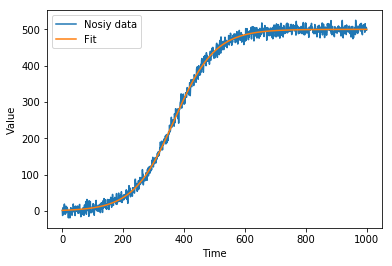

In [5]:
from __future__ import print_function
import pints
import pints.toy as toy
import numpy as np
import matplotlib.pyplot as pl

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
values = model.simulate(real_parameters, times)

# Add noise
values += np.random.normal(0, 10, values.shape)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Select a score function
score = pints.SumOfSquaresError(problem)

# Select some boundaries
boundaries = pints.RectangularBoundaries([0, 400], [0.03, 600])

# Perform an optimization with boundaries and hints
x0 = 0.01, 450
sigma0 = [0.01, 100]
found_parameters, found_value = pints.optimise(
    score,
    x0,
    sigma0,
    boundaries,
    method=pints.CMAES
    )

# Show score of true solution
print('Score at true solution: ')
print(score(real_parameters))

# Compare parameters with original
print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(real_parameters[k]))

# Show quality of fit
pl.figure()
pl.xlabel('Time')
pl.ylabel('Value')
pl.plot(times, values, label='Nosiy data')
pl.plot(times, problem.evaluate(found_parameters), label='Fit')
pl.legend()
pl.show()